# Introduction

The COVID-19 pandemic has placed immense pressure on hospitals, which serve as the frontline defense against the virus. Rapid and accurate identification of COVID-positive patients is crucial for managing hospital resources, ensuring patient safety, and preventing the virus's spread within healthcare facilities. Traditional methods of diagnosing COVID-19 often rely on extensive manual testing and delayed laboratory results, which can strain hospital workflows and lead to inefficient resource allocation.

This project on exploring correlation of symptoms to cluster patients in order to identif susceptibility group tailored for hospital use. Leveraging patient data such as symptoms, vital signs, and demographic information. By prioritizing the identification of COVID signs we can proactively alert the population of things to watch out for.

# Data  Load

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
import scipy.stats as scstat
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pycountry

In [4]:
# Optional cell from Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
file_path1 = "/content/drive/My Drive/Colab Notebooks/2nd/hospital1.xlsx"
file_path2 = "/content/drive/My Drive/Colab Notebooks/2nd/hospital2.xlsx"

hospital1 = pd.read_excel(file_path1)
hospital2 = pd.read_excel(file_path2)

In [6]:
# Print all data and reset (avoids truncating)
def print_all_df(df_data):
  # Adjust display options
  pd.set_option('display.max_rows', None)  # Show all rows
  pd.set_option('display.max_columns', None)  # Show all columns
  pd.set_option('display.width', None)  # Expand the display width
  pd.set_option('display.max_colwidth', None)  # Expand the max column width

  print(df_data)

  # Reset to default options if needed
  pd.reset_option('display.max_rows')
  pd.reset_option('display.max_columns')
  pd.reset_option('display.width')
  pd.reset_option('display.max_colwidth')



## Function to analyze the hospitals


### Quick look to the data

In [7]:
hospital1.head()

,patient ID,patient ID.1,nationality,age,gender K=female E=male,date_of_first_symptoms,BASVURUTARIHI,fever_temperature,oxygen_saturation,history_of_fever,...,chronic_hematologic_disease,AIDS_HIV,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks,PCR_result
0,11850006,11850006,T.C.,47,K,2022-01-01,2022-01-01,38.2,96.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
1,4373630,4373630,T.C.,23,K,2022-01-01,2022-01-01,37.0,96.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
2,12172023,12172023,T.C.,26,K,2022-01-01,2022-01-01,38.0,95.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
3,72856168,72856168,T.C.,60,K,2022-01-01,2022-01-01,36.5,95.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
4,72200559,72200559,T.C.,72,K,2021-12-22,2021-12-22,36.9,96.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive


In [8]:
hospital2.head()

,patient_id,admission_id,country_of_residence,age,sex,date_of_first_symptoms,admission_date,fever_temperature,oxygen_saturation,history_of_fever,...,chronic_hematologic_disease,AIDS_HIV,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks,PCR_result
0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
1,88567155.0,45.0,T.C.,52.0,E=male K=female,2021-03-01 00:00:00,2021-03-01 00:00:00,37.3,-1.0,0.0,...,0,0,0,0,0,0,0,0,0,positive
2,36069621.0,181.0,T.C.,47.0,K,2021-03-01 08:38:00,2021-03-01 08:38:00,38.0,95.0,1.0,...,0,0,0,0,0,0,0,0,0,positive
3,57644199.0,36.0,T.C.,36.0,K,2021-03-01 08:39:00,2021-03-01 08:39:00,37.5,88.0,0.0,...,0,0,0,0,0,0,0,0,0,positive
4,81365404.0,32.0,T.C.,30.0,E,2021-03-01 09:25:00,2021-03-01 09:25:00,37.8,87.0,1.0,...,0,0,0,0,0,0,0,0,0,positive


### Function

In [9]:
#Wrote this function after observing the data for approximately 5 minutes

def analyze_hospital_data(df):
    """
    Analyze and visualize data from a hospital dataset.

    Parameters:
    - df: DataFrame, the hospital dataset.
    """
    # Automatically identify numerical columns
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

    symptoms_columns = [
        'history_of_fever', 'cough',
        'sore_throat', 'runny_nose', 'wheezing', 'shortness_of_breath',
        'lower_chest_wall_indrawing', 'chest_pain', 'conjunctivitis',
        'lymphadenopathy', 'headache', 'loss_of_smell', 'loss_of_taste',
        'fatigue_malaise', 'anorexia', 'altered_consciousness_confusion',
        'muscle_aches', 'joint_pain', 'inability_to_walk', 'abdominal_pain',
        'diarrhoea', 'vomiting_nausea', 'skin_rash', 'bleeding', 'other_symptoms',
        'chronic_cardiac_disease', 'hypertension', 'chronic_pulmonary_disease',
        'asthma', 'chronic_kidney_disease', 'obesity', 'liver_disease', 'asplenia',
        'chronic_neurological_disorder', 'malignant_neoplasm',
        'chronic_hematologic_disease', 'AIDS_HIV', 'diabetes_mellitus_type_1',
        'diabetes_mellitus_type_2', 'rheumatologic_disorder', 'dementia',
        'tuberculosis', 'smoking', 'other_risks'
    ]

    # Automatically identify date column
    date_column = 'admission_date' if 'admission_date' in df.columns else None

    # Automatically identify gender column
    gender_column = [col for col in df.columns if 'gender' in col.lower() or 'sex' in col.lower()]
    gender_column = gender_column[0] if gender_column else None

    # 1. General information about the dataset
    print("Dataset Information:\n")
    df.info()
    print("\nColumn Names:\n", df.columns.tolist())
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nBasic Statistics:\n", df.describe())
    print("\nNumber of Duplicate Rows:\n", df.duplicated().sum())

    # 2. Correlation Heatmap
    print("\nGenerating Correlation Heatmap...")
    correlation_matrix = df[numerical_columns].corr()
    plt.figure(figsize=(20, 16))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        cbar=True,
        linewidths=0.5,
    )
    plt.title('Correlation Heatmap', fontsize=20, pad=20)
    plt.xticks(fontsize=10, rotation=90)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    # 3. Distribution of Fever Temperatures
    if 'fever_temperature' in df.columns:
        print("\nGenerating Fever Temperature Distribution...")
        plt.figure(figsize=(12, 6))
        df['fever_temperature'].hist(bins=30, edgecolor='black', alpha=0.7)
        plt.title('Distribution of Fever Temperatures', fontsize=16, pad=20)
        plt.xlabel('Fever Temperature (°C)', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.xticks(fontsize=12, rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    # 4. Gender Distribution
    if gender_column:
        print("\nGenerating Gender Distribution...")
        plt.figure(figsize=(12, 6))
        df[gender_column].value_counts().plot(kind='bar', edgecolor='black', alpha=0.7)
        plt.title('Gender Distribution of Patients', fontsize=16, pad=20)
        plt.xlabel('Gender', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.xticks(fontsize=12, rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    # 5. Frequency of Each Symptom
    if symptoms_columns:

      print("\nCheck if any symptoms column has abnormal values")
      for symptom in symptoms_columns:
        values = hospital1[symptom].unique()
        if len(values) != 2:
            print("Column {} has {} values!".format(symptom, values.tolist()))

      print("\nGenerating Symptom Frequency Distribution (Top 20)...")

      # Calculate the sum for each symptom and sort by frequency
      symptom_counts = df[symptoms_columns].sum().sort_values(ascending=False)

      # Select the top 20 symptoms
      top_20_symptoms = symptom_counts.head(20)

      # Plot the top 20 symptoms
      top_20_symptoms.plot(kind='bar', figsize=(16, 8), edgecolor='black', alpha=0.7)

      # Add titles and labels
      plt.title('Top 20 Most Frequent Symptoms', fontsize=16, pad=20)
      plt.xlabel('Symptoms', fontsize=14)
      plt.ylabel('Frequency', fontsize=14)
      plt.xticks(fontsize=12, rotation=45)
      plt.grid(axis='y', linestyle='--', alpha=0.7)
      plt.tight_layout()
      plt.show()

## Analyzing hospital1

In [10]:
#Taking a quick look to the data
hospital1.head()

,patient ID,patient ID.1,nationality,age,gender K=female E=male,date_of_first_symptoms,BASVURUTARIHI,fever_temperature,oxygen_saturation,history_of_fever,...,chronic_hematologic_disease,AIDS_HIV,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks,PCR_result
0,11850006,11850006,T.C.,47,K,2022-01-01,2022-01-01,38.2,96.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
1,4373630,4373630,T.C.,23,K,2022-01-01,2022-01-01,37.0,96.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
2,12172023,12172023,T.C.,26,K,2022-01-01,2022-01-01,38.0,95.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
3,72856168,72856168,T.C.,60,K,2022-01-01,2022-01-01,36.5,95.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
4,72200559,72200559,T.C.,72,K,2021-12-22,2021-12-22,36.9,96.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive


Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14712 entries, 0 to 14711
Data columns (total 54 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   patient ID                       14712 non-null  int64         
 1   patient ID.1                     14712 non-null  int64         
 2   nationality                      14712 non-null  object        
 3   age                              14712 non-null  int64         
 4   gender K=female E=male           14712 non-null  object        
 5   date_of_first_symptoms           14712 non-null  datetime64[ns]
 6   BASVURUTARIHI                    14712 non-null  datetime64[ns]
 7   fever_temperature                14244 non-null  float64       
 8   oxygen_saturation                14708 non-null  float64       
 9   history_of_fever                 14712 non-null  int64         
 10  cough                            147

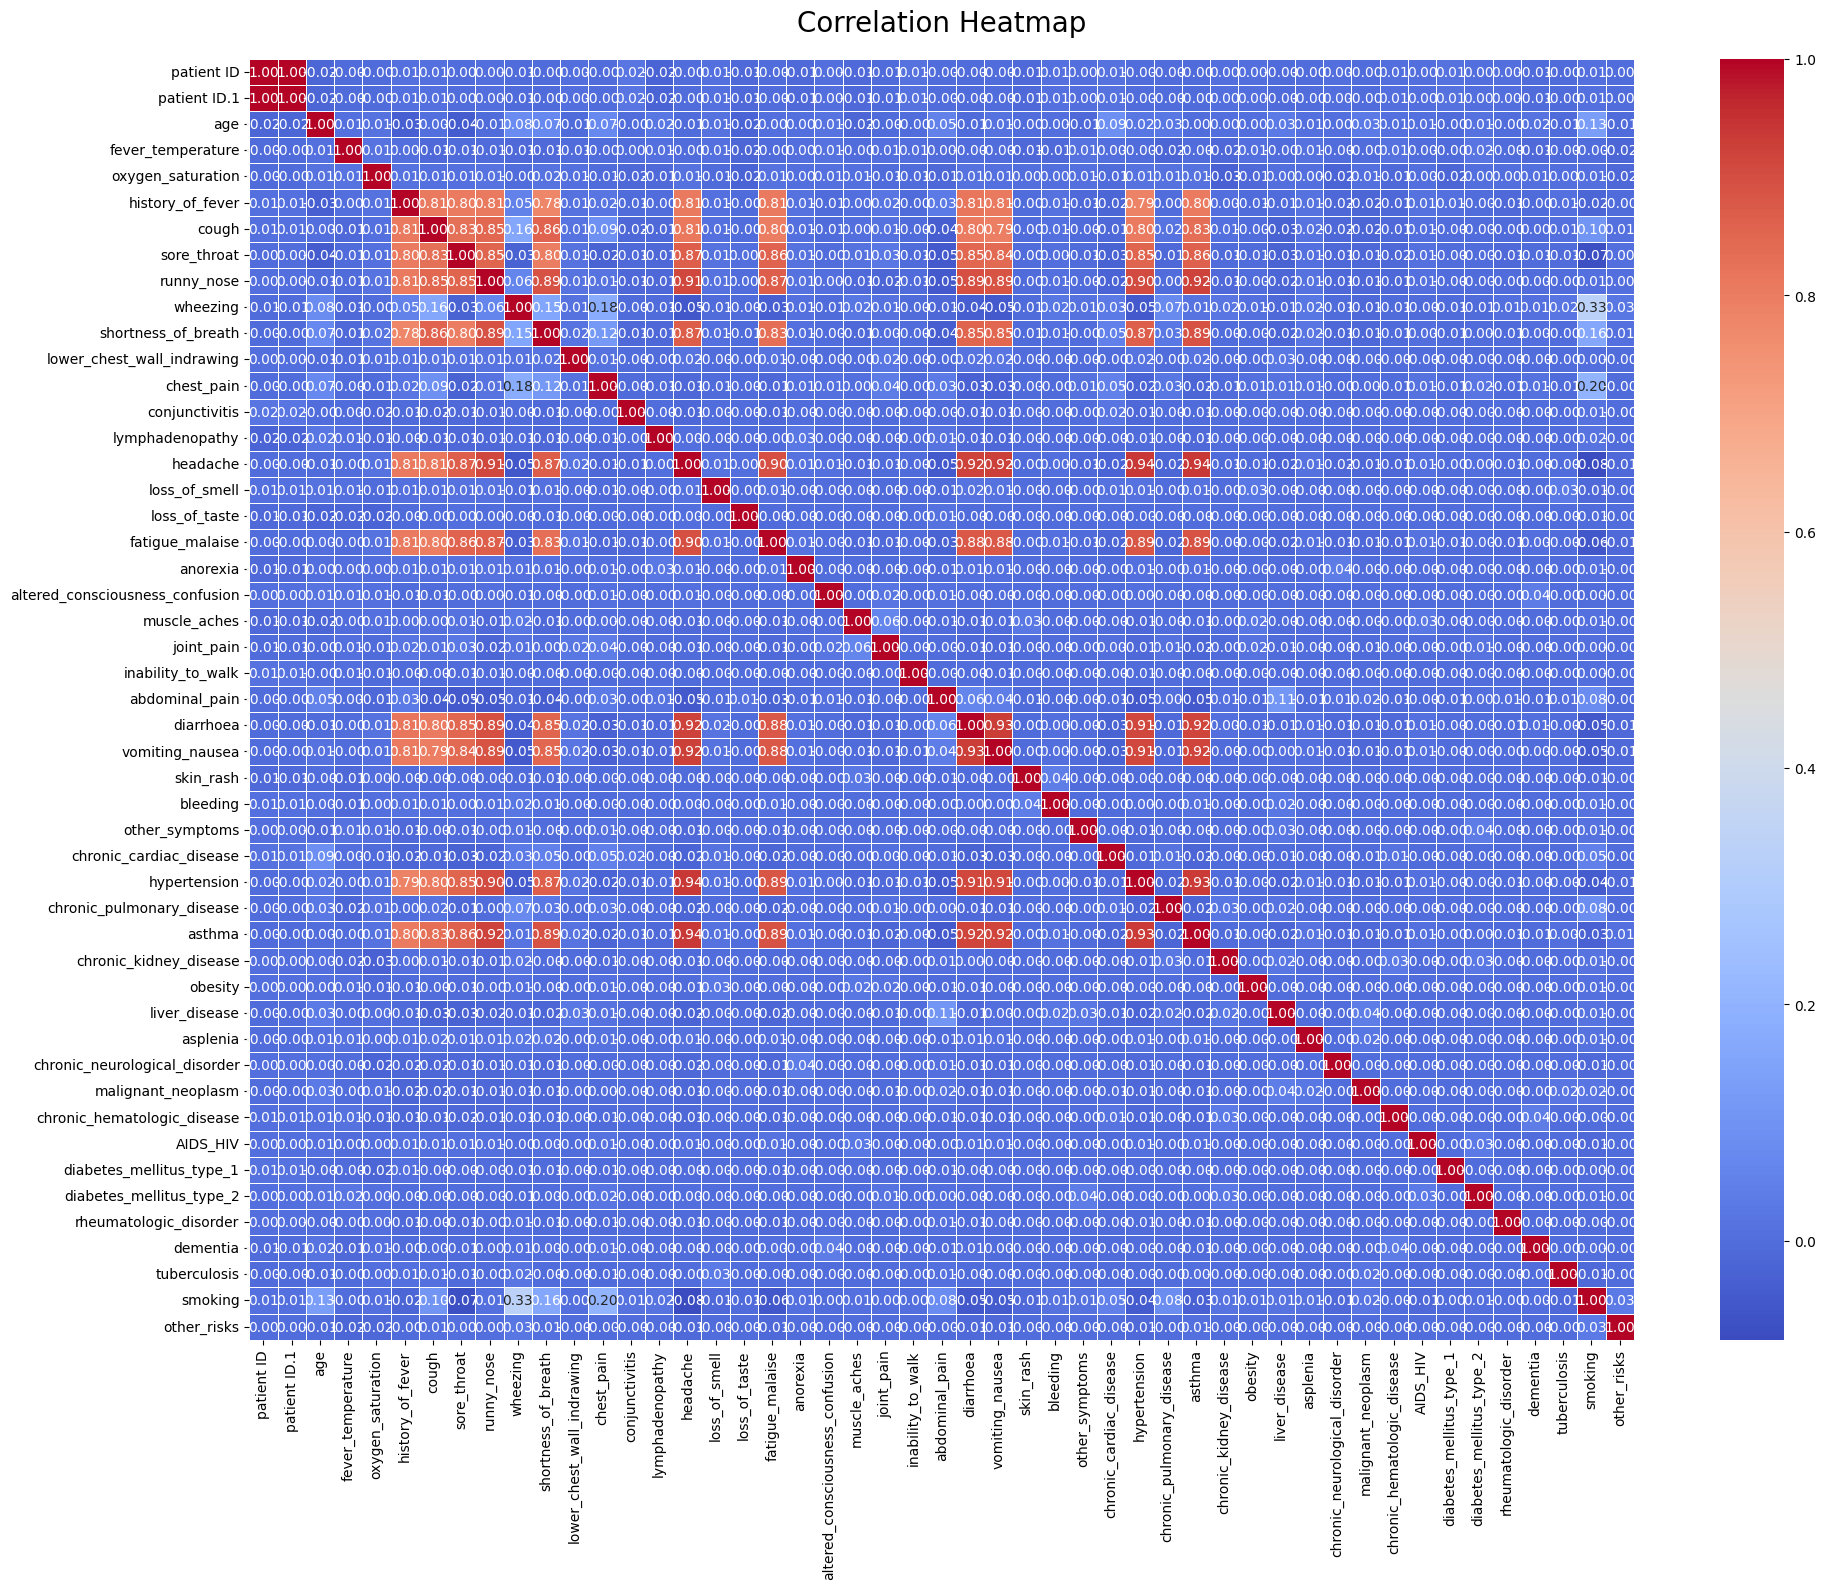


Generating Fever Temperature Distribution...


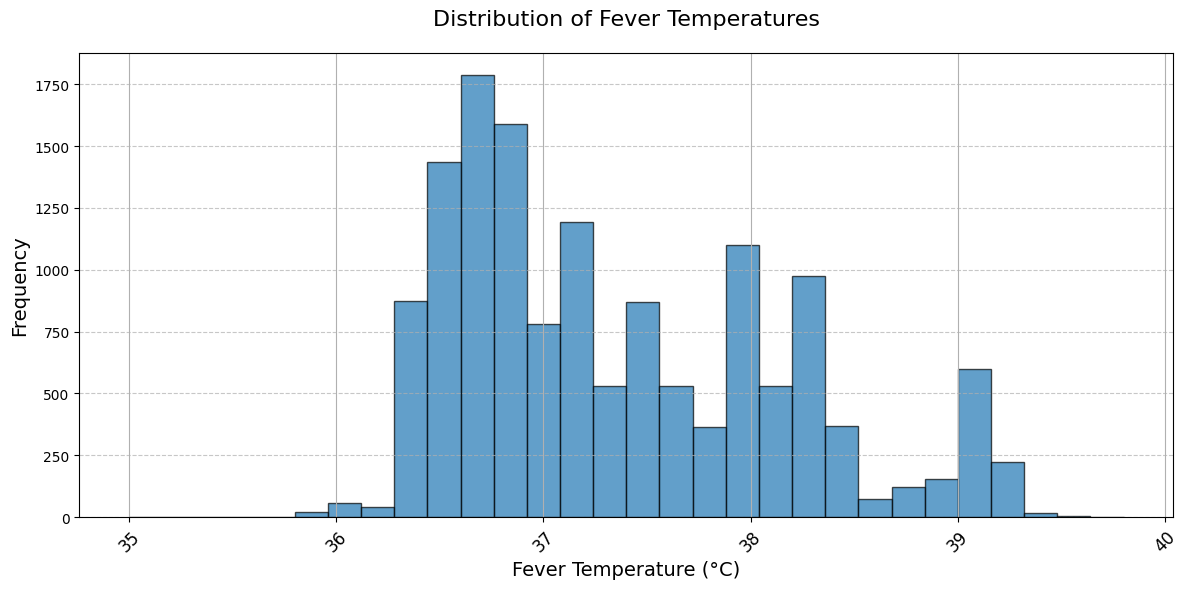


Generating Gender Distribution...


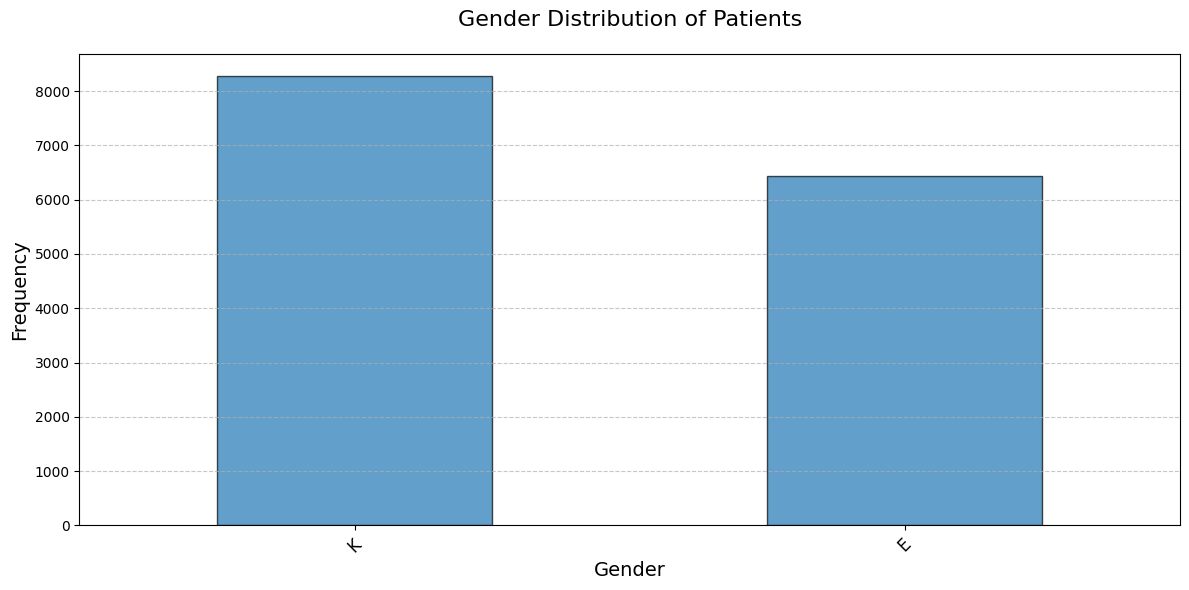


Check if any symptoms column has abnormal values
Column chronic_kidney_disease has [0.0, 1.0, nan] values!
Column obesity has [0.0, 1.0, nan] values!
Column liver_disease has [0.0, 1.0, nan] values!
Column asplenia has [0.0, 1.0, nan] values!
Column chronic_neurological_disorder has [0.0, nan, 1.0] values!
Column chronic_hematologic_disease has [0.0, nan, 1.0] values!
Column AIDS_HIV has [0.0, nan, 1.0] values!
Column diabetes_mellitus_type_1 has [0.0, nan, 1.0] values!
Column diabetes_mellitus_type_2 has [0.0, nan, 1.0] values!
Column rheumatologic_disorder has [0.0, nan, 1.0] values!
Column dementia has [0.0, nan, 1.0] values!

Generating Symptom Frequency Distribution (Top 20)...


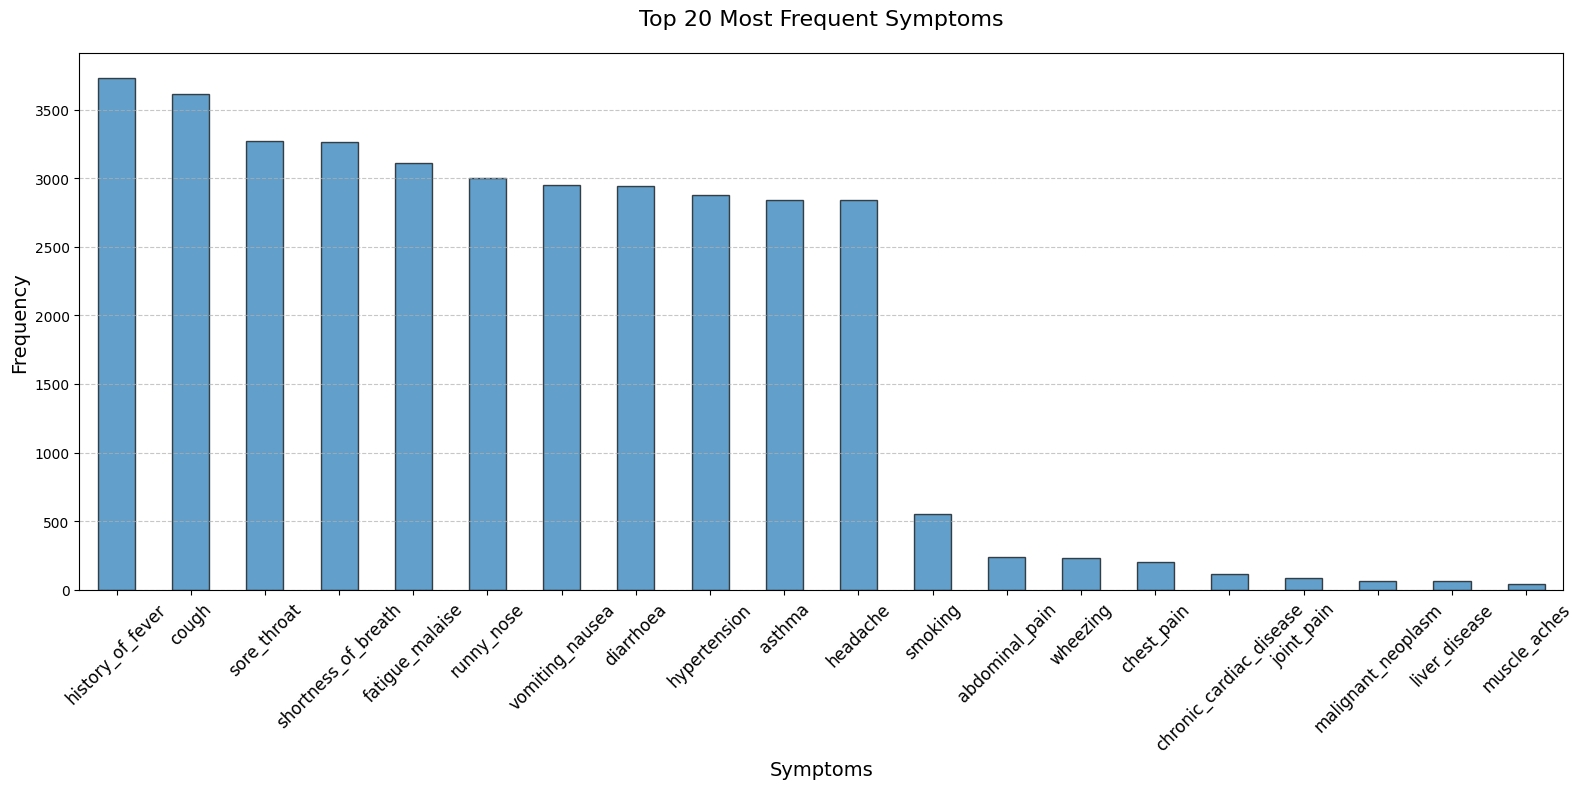

In [11]:
# Analyzing hospital 1
analyze_hospital_data(hospital1)

### Data Observations of hospital1

- patient ID and patient ID.1 are exactly the same based on the correlation matrix

- data types needs to be modified (fever_temperature) (goal is to make every column the same data type as in hospital2, only the temperatue float the other numberic data will be integer

- many missing values in  PCR_results: 1176 --> 0: negative, 1:positive, 2: no result)

- no duplicate rows

- column names needs to be standardized (turkish admission date :D )

- High variation is presented in important traits such as high temperatures, consider maybe reduce dataset

- Symptoms columns present nan values

## Analyzing hospital2

In [12]:
#Taking a quick look to the data
hospital2.head()

,patient_id,admission_id,country_of_residence,age,sex,date_of_first_symptoms,admission_date,fever_temperature,oxygen_saturation,history_of_fever,...,chronic_hematologic_disease,AIDS_HIV,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks,PCR_result
0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
1,88567155.0,45.0,T.C.,52.0,E=male K=female,2021-03-01 00:00:00,2021-03-01 00:00:00,37.3,-1.0,0.0,...,0,0,0,0,0,0,0,0,0,positive
2,36069621.0,181.0,T.C.,47.0,K,2021-03-01 08:38:00,2021-03-01 08:38:00,38.0,95.0,1.0,...,0,0,0,0,0,0,0,0,0,positive
3,57644199.0,36.0,T.C.,36.0,K,2021-03-01 08:39:00,2021-03-01 08:39:00,37.5,88.0,0.0,...,0,0,0,0,0,0,0,0,0,positive
4,81365404.0,32.0,T.C.,30.0,E,2021-03-01 09:25:00,2021-03-01 09:25:00,37.8,87.0,1.0,...,0,0,0,0,0,0,0,0,0,positive


Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12737 entries, 0 to 12736
Data columns (total 54 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   patient_id                       12734 non-null  float64       
 1   admission_id                     12734 non-null  float64       
 2   country_of_residence             12734 non-null  object        
 3   age                              12734 non-null  float64       
 4   sex                              12734 non-null  object        
 5   date_of_first_symptoms           12734 non-null  datetime64[ns]
 6   admission_date                   12734 non-null  datetime64[ns]
 7   fever_temperature                11515 non-null  float64       
 8   oxygen_saturation                12730 non-null  float64       
 9   history_of_fever                 12729 non-null  float64       
 10  cough                            127

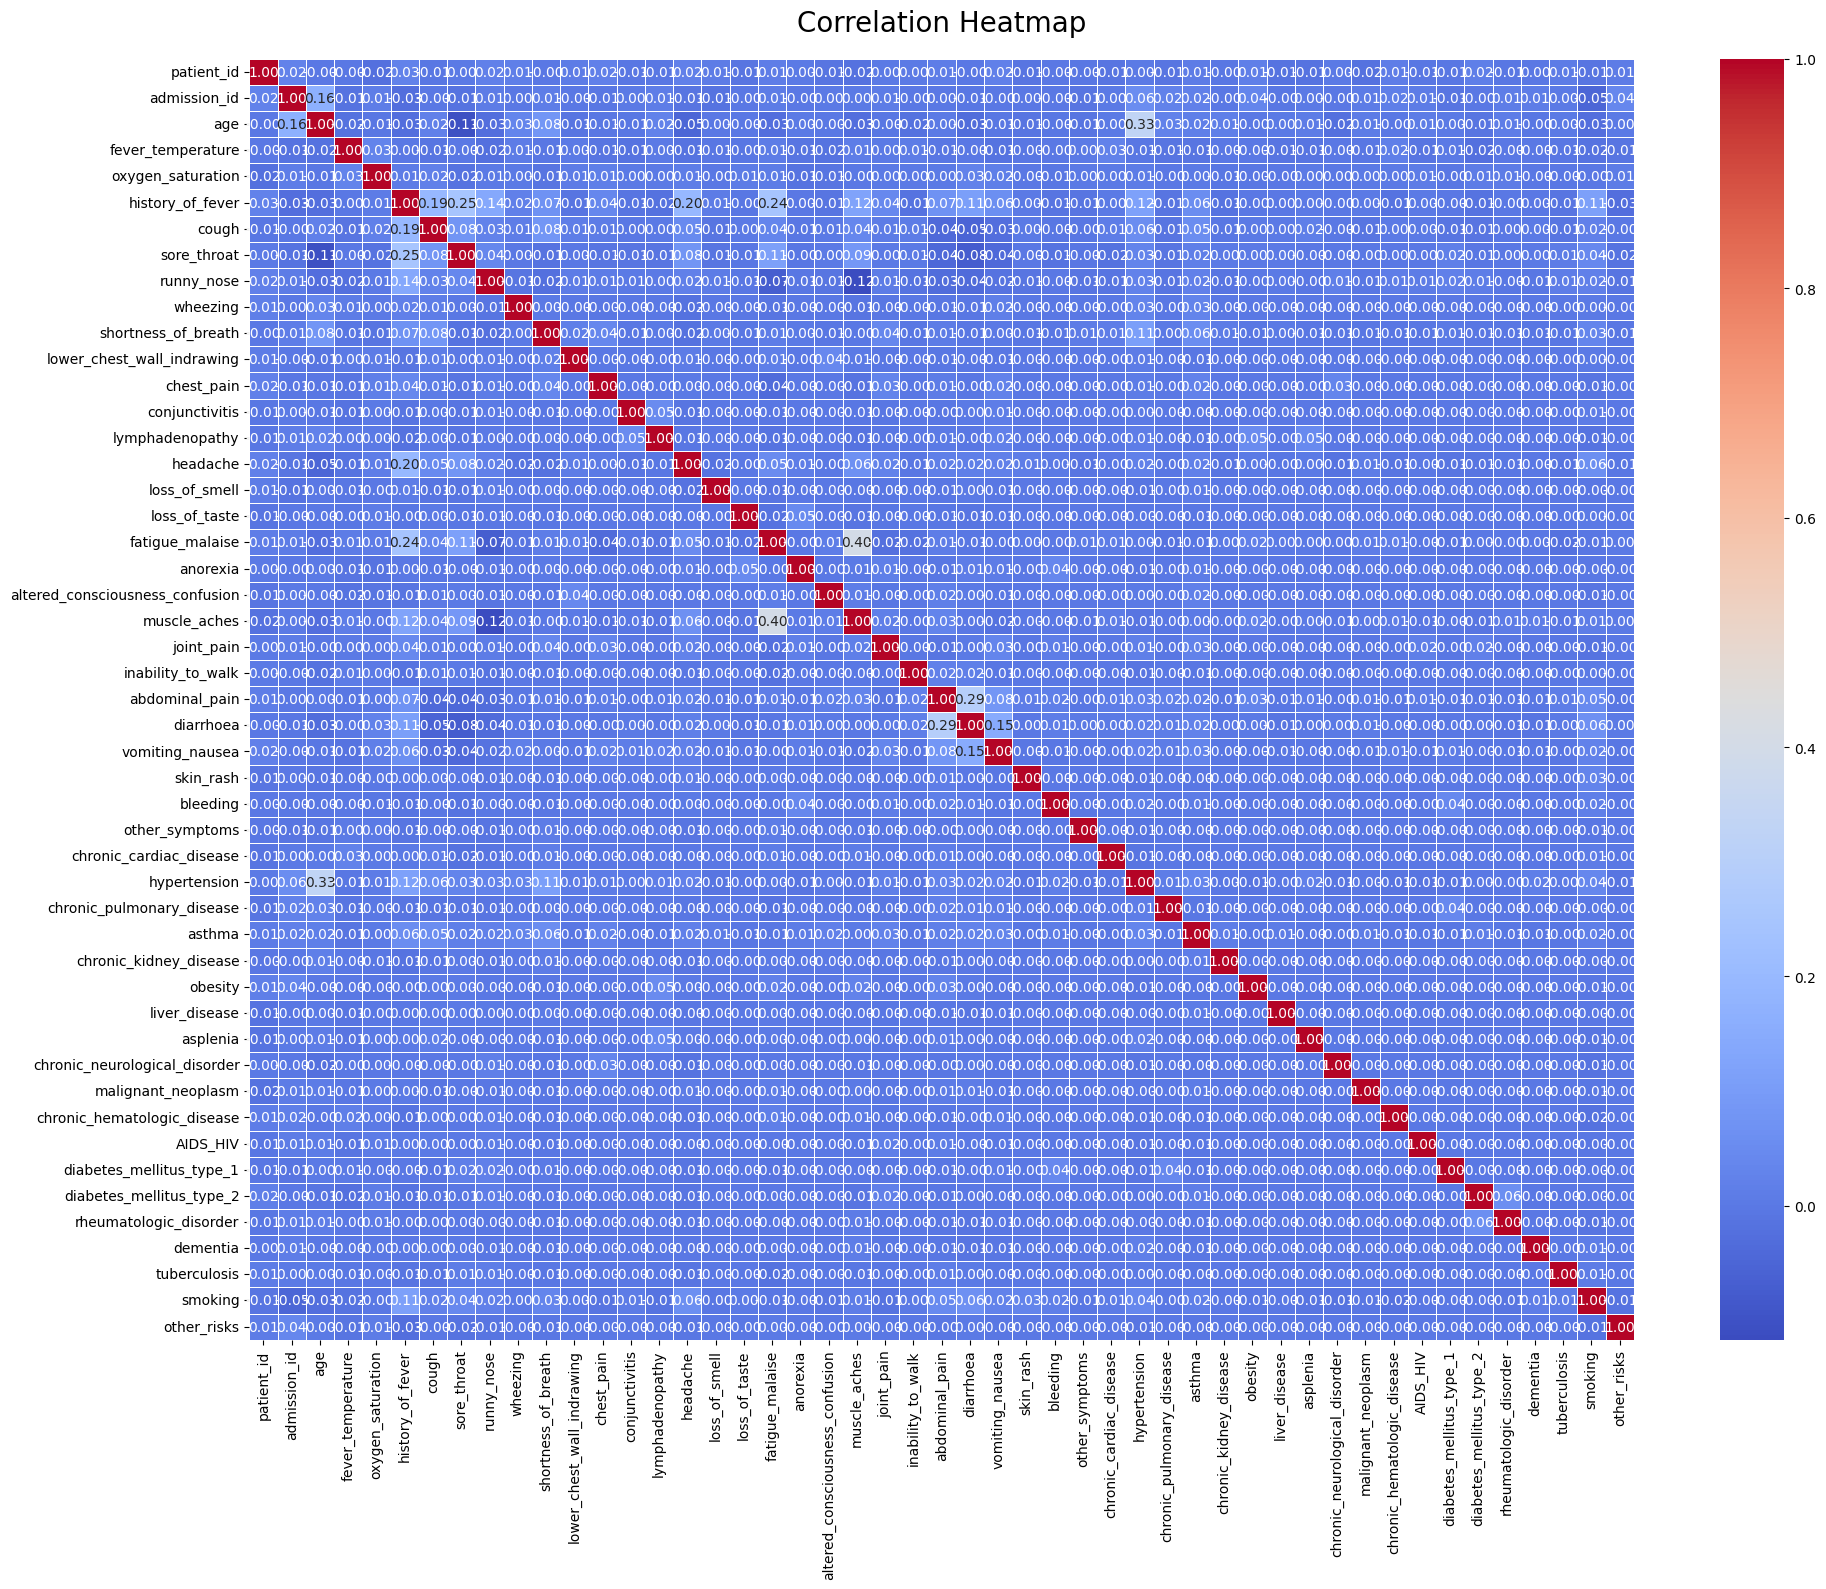


Generating Fever Temperature Distribution...


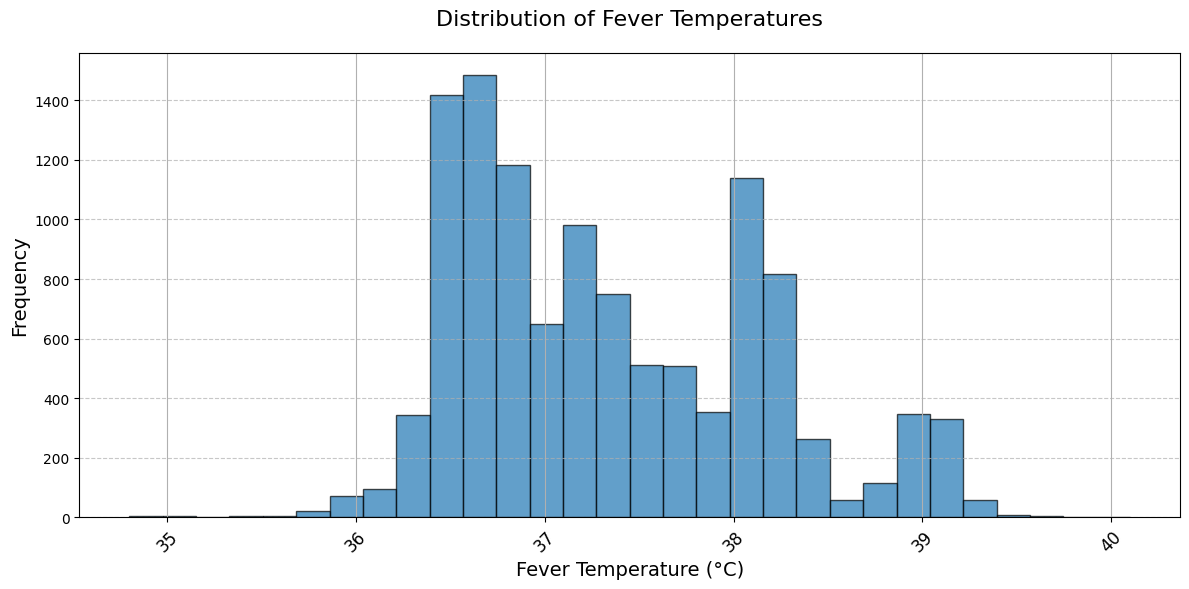


Generating Gender Distribution...


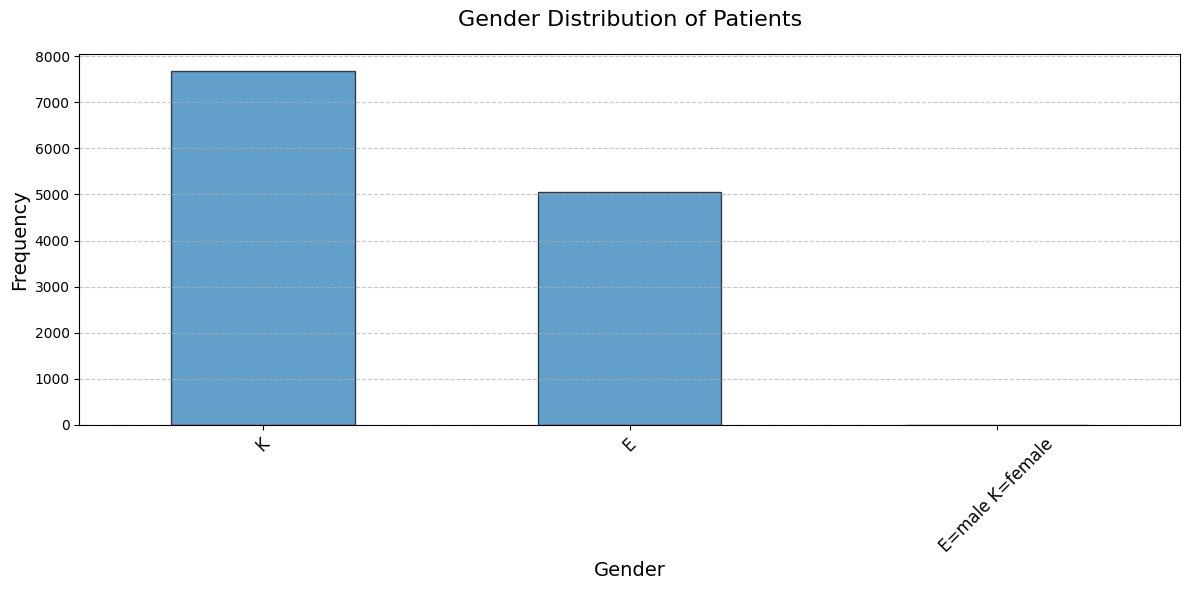


Check if any symptoms column has abnormal values
Column chronic_kidney_disease has [0.0, 1.0, nan] values!
Column obesity has [0.0, 1.0, nan] values!
Column liver_disease has [0.0, 1.0, nan] values!
Column asplenia has [0.0, 1.0, nan] values!
Column chronic_neurological_disorder has [0.0, nan, 1.0] values!
Column chronic_hematologic_disease has [0.0, nan, 1.0] values!
Column AIDS_HIV has [0.0, nan, 1.0] values!
Column diabetes_mellitus_type_1 has [0.0, nan, 1.0] values!
Column diabetes_mellitus_type_2 has [0.0, nan, 1.0] values!
Column rheumatologic_disorder has [0.0, nan, 1.0] values!
Column dementia has [0.0, nan, 1.0] values!

Generating Symptom Frequency Distribution (Top 20)...


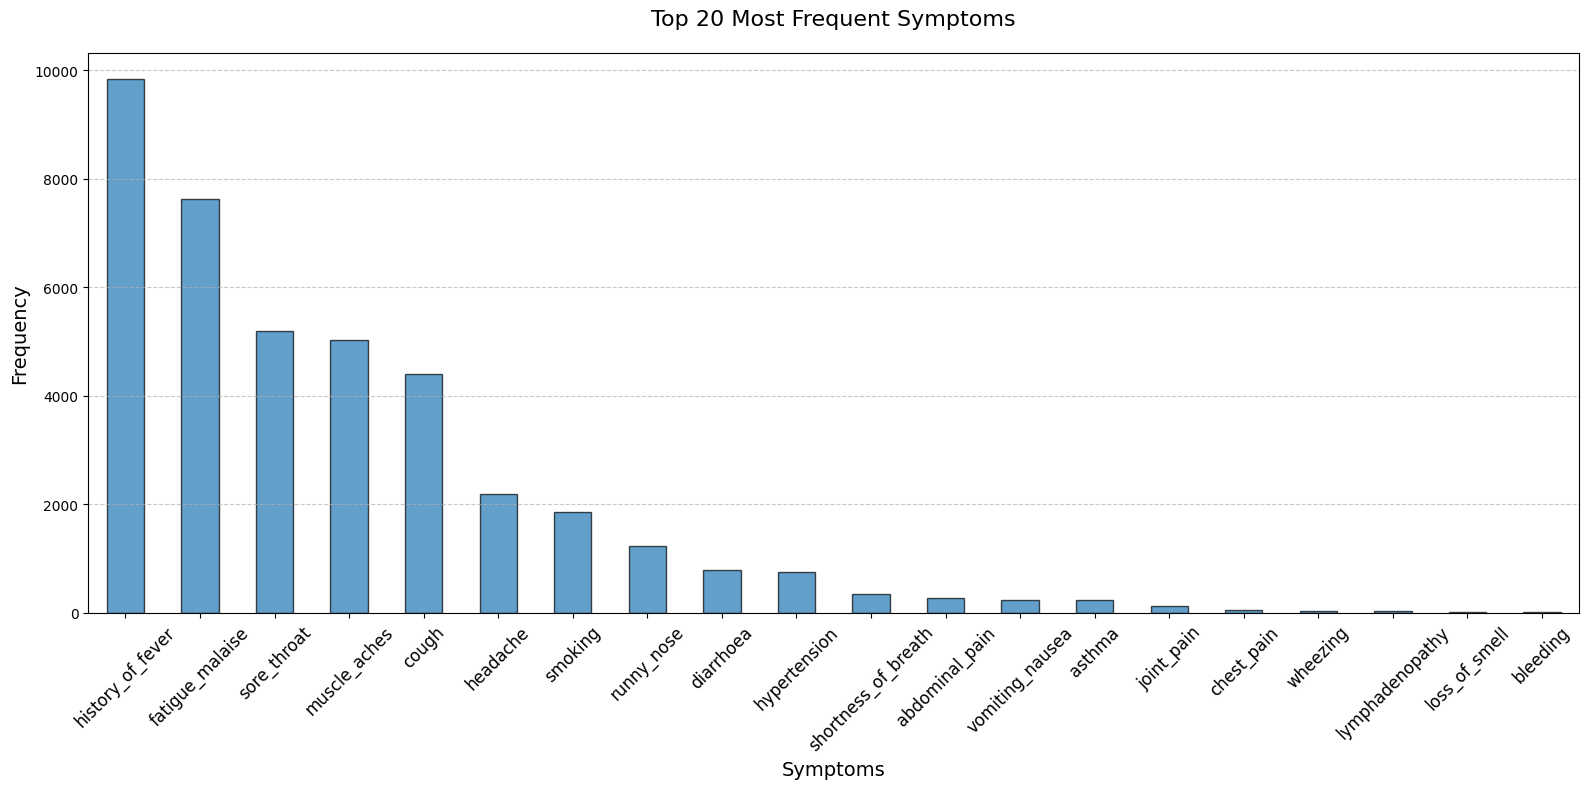

In [13]:
# Analyzing hospital 2
analyze_hospital_data(hospital2)

### Data Observations of hospital2

- many missing value in temperature (1222)

- in the gender distribution there is a third category, because of legend between the data

- column names needs to be standardized

- entire rows of data have NaN values

- Symptoms columns present nan values

## Comparing data between hospital1 and hospital2

## Standarizing/comparing data types and names

In [14]:
import io  # Import the io module to handle in-memory text streams

# Capture the .info() output of hospital1_copy
buffer1 = io.StringIO()  # Create a text buffer
hospital1.info(buf=buffer1)  # Write the .info() output to the buffer
info1 = buffer1.getvalue()  # Get the buffer content as a string

# Capture the .info() output of hospital2_copy
buffer2 = io.StringIO()  # Create another text buffer
hospital2.info(buf=buffer2)  # Write the .info() output to the buffer
info2 = buffer2.getvalue()  # Get the buffer content as a string

# Print the headers for both datasets
print("Hospital 1 Info:".ljust(50) + "Hospital 2 Info:")
print("-" * 50 + " " + "-" * 50)  # Add a dividing line

# Print the .info() output of both datasets side by side
for line1, line2 in zip(info1.splitlines(), info2.splitlines()):  # Match lines from both outputs
    print(line1.ljust(50) + line2)  # Align text to make it easier to read

# Remove any False Positives by standarizing to lower-case and replace spaces with "-"
hospital1.columns = hospital1.columns.str.strip().str.lower().str.replace(' ', '_')
hospital2.columns = hospital2.columns.str.strip().str.lower().str.replace(' ', '_')

unique_columns_h1 = hospital1.columns.difference(hospital2.columns)
unique_columns_h2 = hospital2.columns.difference(hospital1.columns)
common_columns_names = hospital1.columns.intersection(hospital2.columns)

print("\nHospital 1 has {} different column names: {}".format(len(unique_columns_h1), unique_columns_h1.to_list()))
print("Hospital 2 has {} different column names: {}".format(len(unique_columns_h2), unique_columns_h2.to_list()))

print("\nHospitals share {} columnn names".format(len(common_columns_names)))

common_columns_names_mismatch = []
# For each common column check D-Types
for col in common_columns_names:
    h1D=hospital1[col].dtype
    h2D=hospital2[col].dtype
    if h1D != h2D:
        common_columns_names_mismatch.append(col)
        print("Column name {} is different type in hospital 1 ({}) and hospital 2 ({})".format(col, h1D, h2D))


Hospital 1 Info:                                  Hospital 2 Info:
-------------------------------------------------- --------------------------------------------------
<class 'pandas.core.frame.DataFrame'>             <class 'pandas.core.frame.DataFrame'>
RangeIndex: 14712 entries, 0 to 14711             RangeIndex: 12737 entries, 0 to 12736
Data columns (total 54 columns):                  Data columns (total 54 columns):
 #   Column                           Non-Null Count  Dtype          #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         ---  ------                           --------------  -----         
 0   patient ID                       14712 non-null  int64          0   patient_id                       12734 non-null  float64       
 1   patient ID.1                     14712 non-null  int64          1   admission_id                     12734 non-null  float64       
 2   nationality        

### Analisis

Symptoms cells appear to only have 1,0 or Nan. In order to standarize it we need to convert the values from float64 to int64 since they are discrete values and remove NaN

# Data preparation

## Standardization

In [15]:
# Create a copy of hospital1 and hospital2 dataset to avoid modifying the original
hospital1_copy = hospital1.copy()
hospital2_copy = hospital2.copy()

In [16]:
# Making the column names similar after inspection
hospital1_copy.rename(columns={'basvurutarihi': 'admission_date'}, inplace=True) #basvurutarihi means admission date in turkish
hospital1_copy.rename(columns={'patient_id.1': 'admission_id'}, inplace=True)
hospital1_copy.rename(columns={'gender_k=female_e=male': 'sex'}, inplace=True)
hospital2_copy.rename(columns={'country_of_residence': 'nationality'}, inplace=True)

# Dropping data, where the nationalities are NaN because country plays a big role on population density.
# Filling the values doesn't seem right since each population has it's own traits
hospital1_copy = hospital1_copy[~hospital1_copy['nationality'].isnull()]
hospital2_copy = hospital2_copy[~hospital2_copy['nationality'].isnull()]

In [17]:
#Modifying the patient_id to integer in hospital2_copy
hospital2_copy['patient_id'] = hospital2_copy['patient_id'].astype(int)

# Check the updated column
print(hospital2_copy['patient_id'].head())

1    88567155
2    36069621
3    57644199
4    81365404
5    82027164
Name: patient_id, dtype: int64


In [18]:
hospital1_copy.head()

,patient_id,admission_id,nationality,age,sex,date_of_first_symptoms,admission_date,fever_temperature,oxygen_saturation,history_of_fever,...,chronic_hematologic_disease,aids_hiv,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks,pcr_result
0,11850006,11850006,T.C.,47,K,2022-01-01,2022-01-01,38.2,96.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
1,4373630,4373630,T.C.,23,K,2022-01-01,2022-01-01,37.0,96.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
2,12172023,12172023,T.C.,26,K,2022-01-01,2022-01-01,38.0,95.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
3,72856168,72856168,T.C.,60,K,2022-01-01,2022-01-01,36.5,95.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
4,72200559,72200559,T.C.,72,K,2021-12-22,2021-12-22,36.9,96.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive


In [19]:
hospital2_copy.head()

,patient_id,admission_id,nationality,age,sex,date_of_first_symptoms,admission_date,fever_temperature,oxygen_saturation,history_of_fever,...,chronic_hematologic_disease,aids_hiv,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks,pcr_result
1,88567155,45.0,T.C.,52.0,E=male K=female,2021-03-01 00:00:00,2021-03-01 00:00:00,37.3,-1.0,0.0,...,0,0,0,0,0,0,0,0,0,positive
2,36069621,181.0,T.C.,47.0,K,2021-03-01 08:38:00,2021-03-01 08:38:00,38.0,95.0,1.0,...,0,0,0,0,0,0,0,0,0,positive
3,57644199,36.0,T.C.,36.0,K,2021-03-01 08:39:00,2021-03-01 08:39:00,37.5,88.0,0.0,...,0,0,0,0,0,0,0,0,0,positive
4,81365404,32.0,T.C.,30.0,E,2021-03-01 09:25:00,2021-03-01 09:25:00,37.8,87.0,1.0,...,0,0,0,0,0,0,0,0,0,positive
5,82027164,81.0,T.C.,41.0,K,2021-03-01 09:50:00,2021-03-01 09:50:00,36.9,89.0,0.0,...,0,0,0,0,0,0,0,0,0,positive


## Hospital1


### Checking missing values in hospital1

In [20]:
# Check for missing values in each column
missing_values = hospital1_copy.isnull().sum()

# Filter columns with missing values
columns_with_missing = missing_values[missing_values > 0]

# Display the columns with their missing value counts
print(columns_with_missing)

fever_temperature                 468
oxygen_saturation                   4
chronic_kidney_disease              7
obesity                            22
liver_disease                       6
asplenia                           22
chronic_neurological_disorder       2
chronic_hematologic_disease         2
aids_hiv                            2
diabetes_mellitus_type_1            3
diabetes_mellitus_type_2            2
rheumatologic_disorder              2
dementia                            2
pcr_result                       1176
dtype: int64


### Filling the missing data where it is necessary

#### Mean

We want to make sure to fill continous values with the mean. However we need to make sure to remove outliers if necessary

##### Temperature

In [21]:
sorted_temp_hs1 = np.sort(hospital1_copy['fever_temperature'].dropna())
unique_temp_hs1 = np.unique(sorted_temp_hs1, return_counts=True)

print("Unique temperature values: {}\n".format(len(unique_temp_hs1[0])))

unique_df_hs1 = pd.DataFrame({"Temperatures": unique_temp_hs1[0],"Frequency": unique_temp_hs1[1]})

# Pretty print
unique_df_hs1.transpose()

Unique temperature values: 55



,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
Temperatures,35.0,35.4,35.5,35.7,35.8,35.9,36.0,36.1,36.1,36.2,...,38.9,39.0,39.1,39.2,39.3,39.4,39.4,39.5,39.6,39.8
Frequency,2.0,1.0,1.0,1.0,8.0,11.0,20.0,24.0,13.0,42.0,...,5.0,330.0,269.0,169.0,55.0,12.0,6.0,2.0,2.0,1.0


###### Analysis
Temperatures such as **35-35.5** / **39.5 - 39.8** are not realistic, in order to fill NaN values we need to calculate if a reduce mean is necessary

```python
# Calculate the percentage to remove the first/last 3 values of temperature
(3*56)/100 = 1.68%
```

In [22]:
# Trimmed mean needs to be sorted
print("Trimmed mean: {}".format(scstat.trim_mean(sorted_temp_hs1, proportiontocut=0.0168)))
print("Standard mean: {}".format(sorted_temp_hs1.mean()))

Trimmed mean: 37.33088043004504
Standard mean: 37.343555181128906


Significance is negligible < 0.01 °C. No need apply a trimmed mean

##### Oxygen Saturation

In [23]:
sorted_oxygen_saturation_hs1 = np.sort(hospital1_copy['oxygen_saturation'].dropna())
sorted_oxygen_saturation_hs1 = np.unique(sorted_oxygen_saturation_hs1, return_counts=True)

print("Unique oxygen saturation values: {}\n".format(len(sorted_oxygen_saturation_hs1[0])))

unique_oxy_df_hs1 = pd.DataFrame({"Oxygen Saturation": sorted_oxygen_saturation_hs1[0],"Frequency": sorted_oxygen_saturation_hs1[1]})

# Pretty print
unique_oxy_df_hs1.transpose()

Unique oxygen saturation values: 30



,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Oxygen Saturation,-1.0,0.0,69.0,70.0,71.0,76.0,77.0,78.0,79.0,80.0,...,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100.0
Frequency,16.0,62.0,8.0,12.0,4.0,3.0,18.0,45.0,121.0,155.0,...,204.0,156.0,120.0,901.0,3256.0,3624.0,1833.0,1221.0,522.0,55.0


In [24]:
# Drop first two values (Oxigenation -1 or 0 means patient is dead)
print("Standard mean: {}".format(unique_oxy_df_hs1.iloc[2::]["Oxygen Saturation"].mean()))

Standard mean: 86.07142857142857


In [25]:
# Filling data with mean in fever_temperature

if 'fever_temperature' in hospital1_copy.columns:

    # Calculate the mean of the column, ignoring NaN values with reduced mean to avoid extreme outliers
    mean_value = sorted_temp_hs1.mean()

    # Fill missing values with the mean
    hospital1_copy['fever_temperature'] = hospital1_copy['fever_temperature'].fillna(mean_value)

    # Verify the result
    print(f"Missing values for fever_temperature after filling: {hospital1_copy['fever_temperature'].isnull().sum()}")
    print(f"Filled missing values with the mean: {mean_value}")


# Filling data with mean in oxygen saturation
if 'oxygen_saturation' in hospital1_copy.columns:

    # Calculate the mean of the column, ignoring NaN values with reduced mean to avoid extreme outliers
    mean_value = unique_oxy_df_hs1.iloc[2::]["Oxygen Saturation"].mean()

    # Replace invalids with None
    hospital1_copy.loc[:, 'oxygen_saturation']  = hospital1_copy['oxygen_saturation'].replace({-1: None, 0: None})

    # Fill missing values with the mean
    hospital1_copy['oxygen_saturation'] = hospital1_copy['oxygen_saturation'].fillna(mean_value)

    # Verify the result
    print(f"\nMissing values for oxygen_saturation after filling: {hospital1_copy['oxygen_saturation'].isnull().sum()}")
    print(f"Filled missing values with the mean: {mean_value}")



Missing values for fever_temperature after filling: 0
Filled missing values with the mean: 37.343555181128906

Missing values for oxygen_saturation after filling: 0
Filled missing values with the mean: 86.07142857142857


/tmp/ipython-input-4244636433.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[96.0 96.0 95.0 ... 95.0 96.0 99.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  hospital1_copy.loc[:, 'oxygen_saturation']  = hospital1_copy['oxygen_saturation'].replace({-1: None, 0: None})
/tmp/ipython-input-4244636433.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hospital1_copy['oxygen_saturation'] = hospital1_copy['oxygen_saturation'].fillna(mean_value)


#### Mode

In [26]:
#Filling data with mode where it is necessary, since data is discrete we can compute mean, rather the most frequent value (mode)

# List of columns to fill with the mode
columns_to_fill_mode = [
    'chronic_kidney_disease', 'obesity', 'liver_disease',
    'asplenia', 'chronic_neurological_disorder', 'chronic_hematologic_disease',
    'aids_hiv', 'diabetes_mellitus_type_1', 'diabetes_mellitus_type_2',
    'rheumatologic_disorder', 'dementia'
]

# Fill missing values with the mode for each column in the list
for col in columns_to_fill_mode:
    if col in hospital1_copy.columns:
        most_used = hospital1_copy[col].dropna().mode()
        hospital1_copy[col] = hospital1_copy[col].fillna(most_used[0])

# Verify the result
print(hospital1_copy[columns_to_fill_mode].isnull().sum())  # Should show 0 for all columns


chronic_kidney_disease           0
obesity                          0
liver_disease                    0
asplenia                         0
chronic_neurological_disorder    0
chronic_hematologic_disease      0
aids_hiv                         0
diabetes_mellitus_type_1         0
diabetes_mellitus_type_2         0
rheumatologic_disorder           0
dementia                         0
dtype: int64


####Handling the PCR result column

In [27]:
# Replace 'positive' with 1 and 'negative' with 0
hospital1_copy.loc[:, 'pcr_result']  = hospital1_copy['pcr_result'].replace({'positive': 1, 'negative': 0})

# Drop missing values
hospital1_copy = hospital1_copy.dropna(subset=["pcr_result"])

# Convert the column to integers
hospital1_copy.loc[:, 'pcr_result'] = hospital1_copy['pcr_result'].astype(int)

# Verify the changes
print(hospital1_copy['pcr_result'].value_counts())


pcr_result
1    12434
0     1102
Name: count, dtype: int64


/tmp/ipython-input-2260031033.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hospital1_copy.loc[:, 'pcr_result']  = hospital1_copy['pcr_result'].replace({'positive': 1, 'negative': 0})


#### Replacing gender data

In [28]:
#Converting data in the "sex" column to make it more understandable
# M = Man , F = Female
hospital1_copy.loc[:, 'sex'] = hospital1_copy['sex'].replace({'E': '1', 'K': '0'})

# Verify the changes
print(hospital1_copy['sex'].value_counts())  # Count occurrences of each value

sex
0    7626
1    5910
Name: count, dtype: int64


## Hospital2

### Checking missing values in hospital2

In [29]:
# Check for missing values in each column
missing_values = hospital2_copy.isnull().sum()

# Filter columns with missing values
columns_with_missing = missing_values[missing_values > 0]

# Display the columns with their missing value counts
print(columns_with_missing)

fever_temperature    1219
oxygen_saturation       4
history_of_fever        5
bleeding               36
other_symptoms         36
pcr_result             33
dtype: int64


###Filling the missing data where it is necessary

#### Mean

We want to make sure to fill continous values with the mean. However we need to make sure to remove outliers if necessary

##### Temperature

In [30]:
sorted_temp_h2 = np.sort(hospital2_copy['fever_temperature'].dropna())
unique_temp_h2 = np.unique(sorted_temp_h2, return_counts=True)

print("Unique temperature values: {}\n".format(len(unique_temp_h2[0])))

unique_temp_h2 = pd.DataFrame({"Temperatures": unique_temp_h2[0],"Frequency": unique_temp_h2[1]})

# Pretty print
unique_temp_h2.transpose()

Unique temperature values: 62



,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
Temperatures,34.8,34.9,35.0,35.1,35.2,35.4,35.5,35.6,35.7,35.8,...,38.9,39.0,39.1,39.2,39.3,39.4,39.4,39.5,39.6,40.1
Frequency,1.0,1.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,19.0,...,7.0,225.0,193.0,136.0,57.0,3.0,4.0,1.0,4.0,1.0


###### Analysis
Temperatures such as **34.8-35.5** / **39.5 - 40.1** are not realistic, in order to fill NaN values we need to calculate if a reduce mean is necessary

```python
# Calculate the percentage to remove the first 7 values of temperature
(7*62)/100 = 4.34%

# Calculate the percentage to remove the last 3 values of temperature
(3*62)/100 = 1.86%
```

In [31]:
# Trimmed mean needs to be sorted
print("Trimmed mean: {}".format(scstat.tmean(sorted_temp_h2, limits=[35.5, 39.5])))
print("Standard mean: {}".format(sorted_temp_h2.mean()))

Trimmed mean: 37.34204990002608
Standard mean: 37.341684759009986


Significance is negligible < 0.01 °C. No need apply a trimmed mean

##### Oxygen Saturation

In [32]:
sorted_oxygen_saturation_h2 = np.sort(hospital2_copy['oxygen_saturation'].dropna())
sorted_oxygen_saturation_h2 = np.unique(sorted_oxygen_saturation_h2, return_counts=True)

print("Unique oxygen saturation values: {}\n".format(len(sorted_oxygen_saturation_h2[0])))

unique_oxy_df_hs2 = pd.DataFrame({"Oxygen Saturation": sorted_oxygen_saturation_h2[0],"Frequency": sorted_oxygen_saturation_h2[1]})

# Pretty print
unique_oxy_df_hs2.transpose()

Unique oxygen saturation values: 33



,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
Oxygen Saturation,-1.0,0.0,26.0,68.0,69.0,70.0,71.0,73.0,76.0,77.0,...,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100.0
Frequency,16.0,49.0,1.0,1.0,3.0,11.0,6.0,1.0,2.0,22.0,...,201.0,123.0,118.0,829.0,2752.0,3121.0,1530.0,1036.0,418.0,58.0


In [33]:
# Drop first two values (Oxigenation -1 or 0 means patient is dead)
print("Standard mean: {}".format(unique_oxy_df_hs2.iloc[2::]["Oxygen Saturation"].mean()))

Standard mean: 83.12903225806451


In [34]:
#Filling data with mean in fever_temperature

if 'fever_temperature' in hospital2_copy.columns:
    # Calculate the mean of the column, ignoring NaN values
    mean_value = sorted_temp_h2.mean()

    # Fill missing values with the mean
    hospital2_copy['fever_temperature'] = hospital2_copy['fever_temperature'].fillna(mean_value)

    # Verify the result
    print(f"Missing values after filling: {hospital2_copy['fever_temperature'].isnull().sum()}")
    print(f"Filled missing values with the mean: {mean_value}")


# Filling data with mean in fever_temperature
if 'oxygen_saturation' in hospital2_copy.columns:

    # Calculate the mean of the column, ignoring NaN values with reduced mean to avoid extreme outliers
    mean_value = unique_oxy_df_hs2.iloc[2::]["Oxygen Saturation"].mean()

    # Replace invalids with None
    hospital2_copy.loc[:, 'oxygen_saturation']  = hospital1_copy['oxygen_saturation'].replace({-1: None, 0: None})

    # Fill missing values with the mean
    hospital2_copy['oxygen_saturation'] = hospital2_copy['oxygen_saturation'].fillna(mean_value)

    # Verify the result
    print(f"\nMissing values for oxygen_saturation after filling: {hospital2_copy['oxygen_saturation'].isnull().sum()}")
    print(f"Filled missing values with the mean: {mean_value}")

Missing values after filling: 0
Filled missing values with the mean: 37.341684759009986

Missing values for oxygen_saturation after filling: 0
Filled missing values with the mean: 83.12903225806451


####Mode

In [35]:
#Filling data with median where it is necessary

# List of columns to fill with the median
columns_to_fill_mode = [
    'history_of_fever', 'other_symptoms', 'bleeding', 'sex'
]

# Sex has a format mismatch column
hospital2_copy['sex'] = hospital2_copy['sex'].replace('E=male K=female', None)

# Fill missing values with the median for each column in the list
for col in columns_to_fill_mode:
    if col in hospital2_copy.columns:
        most_used = hospital2_copy[col].dropna().mode()
        hospital2_copy[col] = hospital2_copy[col].fillna(most_used[0])

# Verify the result
print(hospital2_copy[columns_to_fill_mode].isnull().sum())  # Should show 0 for all columns

history_of_fever    0
other_symptoms      0
bleeding            0
sex                 0
dtype: int64


####Handling the PCR result column

In [36]:
# Replace 'positive' with 1 and 'negative' with 0
hospital2_copy.loc[:, 'pcr_result']  = hospital2_copy['pcr_result'].replace({'positive': 1, 'negative': 0})

# Drop missing values
hospital2_copy = hospital2_copy.dropna(subset=["pcr_result"])

# Convert the column to integers
hospital2_copy.loc[:, 'pcr_result'] = hospital2_copy['pcr_result'].astype(int)

# Verify the changes
print(hospital2_copy['pcr_result'].value_counts())

pcr_result
1    9776
0    2925
Name: count, dtype: int64


/tmp/ipython-input-1517403142.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hospital2_copy.loc[:, 'pcr_result']  = hospital2_copy['pcr_result'].replace({'positive': 1, 'negative': 0})


#### Replacing gender data

In [37]:
#Converting data in the "sex" column to make it more understandable
# M = Man , F = Female
hospital2_copy.loc[:, 'sex'] = hospital2_copy['sex'].replace({'E': '1', 'K': '0'})

# Verify the changes
print(hospital2_copy['sex'].value_counts())  # Count occurrences of each value

sex
0    7650
1    5051
Name: count, dtype: int64


## Converting the neccesary columns into integers





In [38]:
#Patiend_id to long just to make sure we do not hit the limit of integers

# List of columns to convert to integers
columns_to_convert = [
    'history_of_fever', 'cough', 'sore_throat', 'runny_nose',
    'wheezing', 'shortness_of_breath', 'lower_chest_wall_indrawing', 'chest_pain',
    'conjunctivitis', 'lymphadenopathy', 'headache', 'loss_of_smell', 'loss_of_taste',
    'fatigue_malaise', 'anorexia', 'altered_consciousness_confusion', 'muscle_aches',
    'joint_pain', 'inability_to_walk', 'abdominal_pain', 'diarrhoea', 'vomiting_nausea',
    'skin_rash', 'bleeding', 'other_symptoms', 'chronic_cardiac_disease', 'hypertension',
    'chronic_pulmonary_disease', 'asthma', 'chronic_kidney_disease', 'obesity',
    'liver_disease', 'asplenia', 'chronic_neurological_disorder', 'malignant_neoplasm',
    'chronic_hematologic_disease', 'AIDS_HIV', 'diabetes_mellitus_type_1',
    'diabetes_mellitus_type_2', 'rheumatologic_disorder', 'dementia', 'tuberculosis',
    'smoking', 'other_risks', 'age', 'admission_id', 'aids_hiv', 'sex', 'pcr_result'
]

# Dictionary to store the count of replaced missing values
missing_value_counts = {}

# For hospital1_copy
for col in columns_to_convert:
    if col in hospital1_copy.columns:  # Check if the column exists in the DataFrame
        # Count missing values before filling
        missing_count = hospital1_copy[col].isnull().sum()

        # Store the count in the dictionary
        missing_value_counts[f"hospital1_copy_{col}"] = missing_count

        # Convert to int
        hospital1_copy[col]  = hospital1_copy[col].astype('int64')

# For hospital2_copy
for col in columns_to_convert:
    if col in hospital2_copy.columns:  # Check if the column exists in the DataFrame
        # Count missing values before filling
        missing_count = hospital2_copy[col].isnull().sum()

        # Store the count in the dictionary
        missing_value_counts[f"hospital2_copy_{col}"] = missing_count

        # Convert to int
        hospital2_copy[col]  = hospital2_copy[col].astype('int64')

# Print the count of replaced missing values larger than 0
for column, count in missing_value_counts.items():
    if count > 0:
      print(f"Column {column}: Replaced {count} missing values")

#If no prints, that means there's no missing data in the two datasets

In [39]:
#Checking if all of the data types are matching

# Capture the .info() output of hospital1_copy
buffer1 = io.StringIO()  # Create a text buffer
hospital1_copy.info(buf=buffer1)  # Write the .info() output to the buffer
info1 = buffer1.getvalue()  # Get the buffer content as a string

# Capture the .info() output of hospital2_copy
buffer2 = io.StringIO()  # Create another text buffer
hospital2_copy.info(buf=buffer2)  # Write the .info() output to the buffer
info2 = buffer2.getvalue()  # Get the buffer content as a string

# Print the headers for both datasets
print("Hospital 1 Info:".ljust(50) + "Hospital 2 Info:")
print("-" * 50 + " " + "-" * 50)  # Add a dividing line

# Print the .info() output of both datasets side by side
for line1, line2 in zip(info1.splitlines(), info2.splitlines()):  # Match lines from both outputs
    print(line1.ljust(50) + line2)  # Align text to make it easier to read

unique_columns_h1 = hospital1_copy.columns.difference(hospital2_copy.columns)
unique_columns_h2 = hospital2_copy.columns.difference(hospital1_copy.columns)
common_columns_names = hospital1_copy.columns.intersection(hospital2_copy.columns)

print("\nHospital 1 has {} different column names: {}".format(len(unique_columns_h1), unique_columns_h1.to_list()))
print("Hospital 2 has {} different column names: {}".format(len(unique_columns_h2), unique_columns_h2.to_list()))

print("\nHospitals share {} columnn names".format(len(common_columns_names)))

common_columns_names_mismatch = []
# For each common column check D-Types
for col in common_columns_names:
    h1D=hospital1_copy[col].dtype
    h2D=hospital2_copy[col].dtype
    if h1D != h2D:
        common_columns_names_mismatch.append(col)
        print("Column name {} is different type in hospital 1 ({}) and hospital 2 ({})".format(col, h1D, h2D))

Hospital 1 Info:                                  Hospital 2 Info:
-------------------------------------------------- --------------------------------------------------
<class 'pandas.core.frame.DataFrame'>             <class 'pandas.core.frame.DataFrame'>
Index: 13536 entries, 0 to 14711                  Index: 12701 entries, 1 to 12734
Data columns (total 54 columns):                  Data columns (total 54 columns):
 #   Column                           Non-Null Count  Dtype          #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         ---  ------                           --------------  -----         
 0   patient_id                       13536 non-null  int64          0   patient_id                       12701 non-null  int64         
 1   admission_id                     13536 non-null  int64          1   admission_id                     12701 non-null  int64         
 2   nationality             

In [40]:
print("Total hospital 1 rows {}".format(hospital1_copy.shape))

hospital1_copy.head() #checking the data once again

Total hospital 1 rows (13536, 54)


,patient_id,admission_id,nationality,age,sex,date_of_first_symptoms,admission_date,fever_temperature,oxygen_saturation,history_of_fever,...,chronic_hematologic_disease,aids_hiv,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks,pcr_result
0,11850006,11850006,T.C.,47,0,2022-01-01,2022-01-01,38.2,96.0,0,...,0,0,0,0,0,0,0,0,0,1
1,4373630,4373630,T.C.,23,0,2022-01-01,2022-01-01,37.0,96.0,1,...,0,0,0,0,0,0,0,0,0,1
2,12172023,12172023,T.C.,26,0,2022-01-01,2022-01-01,38.0,95.0,1,...,0,0,0,0,0,0,0,0,0,1
3,72856168,72856168,T.C.,60,0,2022-01-01,2022-01-01,36.5,95.0,0,...,0,0,0,0,0,0,0,0,0,1
4,72200559,72200559,T.C.,72,0,2021-12-22,2021-12-22,36.9,96.0,0,...,0,0,0,0,0,0,0,0,0,1


In [41]:
print("Total hospital 1 rows {}".format(hospital2_copy.shape))

hospital2_copy.head() #checking the data once again

Total hospital 1 rows (12701, 54)


,patient_id,admission_id,nationality,age,sex,date_of_first_symptoms,admission_date,fever_temperature,oxygen_saturation,history_of_fever,...,chronic_hematologic_disease,aids_hiv,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks,pcr_result
1,88567155,45,T.C.,52,0,2021-03-01 00:00:00,2021-03-01 00:00:00,37.3,96.0,0,...,0,0,0,0,0,0,0,0,0,1
2,36069621,181,T.C.,47,0,2021-03-01 08:38:00,2021-03-01 08:38:00,38.0,95.0,1,...,0,0,0,0,0,0,0,0,0,1
3,57644199,36,T.C.,36,0,2021-03-01 08:39:00,2021-03-01 08:39:00,37.5,95.0,0,...,0,0,0,0,0,0,0,0,0,1
4,81365404,32,T.C.,30,1,2021-03-01 09:25:00,2021-03-01 09:25:00,37.8,96.0,1,...,0,0,0,0,0,0,0,0,0,1
5,82027164,81,T.C.,41,0,2021-03-01 09:50:00,2021-03-01 09:50:00,36.9,95.0,0,...,0,0,0,0,0,0,0,0,0,1


## Merging the two datasets into one for easier model developing

In [42]:
# Concatenate hospital1_copy and hospital2_copy row-wise
merged_hospitals = pd.concat([hospital1_copy, hospital2_copy], axis=0, ignore_index=True)

# Verify the result
print("Shape of merged dataset:", merged_hospitals.shape)
merged_hospitals.head()

Shape of merged dataset: (26237, 54)


,patient_id,admission_id,nationality,age,sex,date_of_first_symptoms,admission_date,fever_temperature,oxygen_saturation,history_of_fever,...,chronic_hematologic_disease,aids_hiv,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks,pcr_result
0,11850006,11850006,T.C.,47,0,2022-01-01,2022-01-01,38.2,96.0,0,...,0,0,0,0,0,0,0,0,0,1
1,4373630,4373630,T.C.,23,0,2022-01-01,2022-01-01,37.0,96.0,1,...,0,0,0,0,0,0,0,0,0,1
2,12172023,12172023,T.C.,26,0,2022-01-01,2022-01-01,38.0,95.0,1,...,0,0,0,0,0,0,0,0,0,1
3,72856168,72856168,T.C.,60,0,2022-01-01,2022-01-01,36.5,95.0,0,...,0,0,0,0,0,0,0,0,0,1
4,72200559,72200559,T.C.,72,0,2021-12-22,2021-12-22,36.9,96.0,0,...,0,0,0,0,0,0,0,0,0,1


## Object columns cleanup

### Country Names

In [43]:
# Important fields like Nationality needs to be cleanup and encoded

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Print all nationalities
print_all_df(merged_hospitals["nationality"].value_counts())

nationality
T.C.                                                 24911
Azerbaijan                                             206
Uzbekistan                                              75
Turkmenistan                                            69
United Kingdom (Great Britain)                          65
Ireland                                                 54
USA                                                     44
Germany                                                 42
France                                                  40
Russia                                                  38
Kyrgyzstan                                              38
Iraq                                                    25
Kazakhstan                                              24
Iran (Islamic Republic of Iran)                         23
Netherlands                                             22
Ethiopia                                                20
Georgia                                     

In [44]:
def standardize_country_name(country):
  # Handle common variations and special cases manually
  custom_mappings = {
      "t.c.": "792",  # Numeric code for Turkey,
      "kuzey kibris tãœrk cum.": "792", # Turkey again
      "diäÿer": "792", # Turkish word
      "united kingdom (great britain)": "826",
      "usa": "840",  # Numeric code for United States
      "iran (islamic republic of iran)": "364",
      "cyprus": "196",
      "kuzėy kibris türk cum.": "196",  # North Cyprus, map to Cyprus
      "rã‰union": "638",  # Reunion
      "the turkish republic of northern cyprus": "196",
      "jordan (hashemite kingdom of jordan)": "400",
      "kosova cumhuriyeti": "412", # Kosovo
      "spain (espaã±a)": "724",
      "bosnia and herzegovä±na": "070",
      "libya (libyan arab jamahirya)": "434",
      "macedonia (former yugoslav republic of macedonia)": "807",
      "democratic republic of the congo": "180",
      "cã”te divoire (ivory coast)": "384", #Côte d'Ivoire - Costa de Marfil
      "palestinian territories": "274", #Franja de Gaza (Palestina)
      "chad (tchad)": "148",
      "slovakia (slovak republic)": "703",
      "saudi arabia (kingdom of saudi arabia)": "682",
  }

  # Check custom mappings first
  if country in custom_mappings:
      return custom_mappings[country]

  # Attempt to find the country using pycountry
  try:
      country = pycountry.countries.get(name=country) or \
                pycountry.countries.search_fuzzy(country)[0]
      return country.numeric  # Return the numeric ISO code
  except (LookupError, AttributeError):
      return country  # Return None if the country is not found


# Normalize name (strip whitespace and convert to lowercase for matching)
merged_hospitals["nationality_numeric"] = merged_hospitals["nationality"].map(lambda x: standardize_country_name(x.strip().lower()))

# Convert the DataFrame to numeric, coercing errors to NaN
merged_hospitals["nationality_numeric"] = merged_hospitals["nationality_numeric"].apply(pd.to_numeric, errors="coerce")

# Identify non-numeric values (where conversion resulted in NaN)
nan_rows = merged_hospitals[merged_hospitals["nationality_numeric"].isna()]

# Print nationalities will failed conversion
print_all_df(nan_rows[["nationality","nationality_numeric"]])

Empty DataFrame
Columns: [nationality, nationality_numeric]
Index: []


### Dates

In [45]:
# List date columns
dates_columns = [
    "date_of_first_symptoms",
    "admission_date"
]

# Convert date portion (regardless of time) to ordinal value
for column in dates_columns:
  merged_hospitals[column] = merged_hospitals[column].apply(lambda x: x.date().toordinal())

# Check results
merged_hospitals[dates_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26237 entries, 0 to 26236
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   date_of_first_symptoms  26237 non-null  int64
 1   admission_date          26237 non-null  int64
dtypes: int64(2)
memory usage: 410.1 KB


In [46]:
# Last check

merged_hospitals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26237 entries, 0 to 26236
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   patient_id                       26237 non-null  int64  
 1   admission_id                     26237 non-null  int64  
 2   nationality                      26237 non-null  object 
 3   age                              26237 non-null  int64  
 4   sex                              26237 non-null  int64  
 5   date_of_first_symptoms           26237 non-null  int64  
 6   admission_date                   26237 non-null  int64  
 7   fever_temperature                26237 non-null  float64
 8   oxygen_saturation                26237 non-null  float64
 9   history_of_fever                 26237 non-null  int64  
 10  cough                            26237 non-null  int64  
 11  sore_throat                      26237 non-null  int64  
 12  runny_nose        

# Modeling

In [47]:
# Check for duplicates
duplicates = merged_hospitals.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Remove duplicates if necessary
merged_hospitals = merged_hospitals.drop_duplicates()

Number of duplicate rows: 0


In [48]:
# Verify the changes and if dataset is balanced
print("Dataset Balance:", merged_hospitals["pcr_result"].value_counts())

Dataset Balance: pcr_result
1    22210
0     4027
Name: count, dtype: int64


In [49]:
# Identify the majority and minority classes
majority_class = merged_hospitals[merged_hospitals["pcr_result"] == 1]
minority_class = merged_hospitals[merged_hospitals["pcr_result"] == 0]

# Oversample the minority class
oversampled_minority = minority_class.sample(len(majority_class), replace=True)

# Combine the majority class with the oversampled minority class
balanced_df = pd.concat([majority_class, oversampled_minority])

# After oversampling, shuffle the dataset to mix the samples
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

# Verify the changes and if dataset is balanced
print("Dataset Balance:", balanced_df["pcr_result"].value_counts())

Dataset Balance: pcr_result
1    22210
0    22210
Name: count, dtype: int64


In [50]:
import sys

#Specify the target column
target_column = 'pcr_result'

# Define non-feature columns to exclude
non_feature_columns = [
    target_column,        # Target variable (e.g., PCR_results)
    "nationality",         # In favor of numeric value,
    "admission_id",
    "patient_id",
    "admission_date"
]

# Drop non-feature columns from the merged dataset
features = merged_hospitals.drop(columns=non_feature_columns)

In [51]:
# Extract the target variable
target = merged_hospitals[target_column]

# Calculate the correlation to the y-value
correlation = features.corrwith(target, method='pearson', numeric_only=True)  # Calculate correlation with the target
correlation_df = correlation.abs().sort_values(ascending=False)  # Sort by absolute correlation

# Print the DataFrame
print(correlation_df)

nationality_numeric                0.162535
history_of_fever                   0.127327
fatigue_malaise                    0.112560
muscle_aches                       0.093631
date_of_first_symptoms             0.086659
cough                              0.071397
shortness_of_breath                0.056838
sore_throat                        0.054375
age                                0.047568
smoking                            0.044256
vomiting_nausea                    0.037238
joint_pain                         0.035591
asthma                             0.035562
hypertension                       0.023091
loss_of_taste                      0.021351
oxygen_saturation                  0.019969
sex                                0.018943
wheezing                           0.017856
headache                           0.015825
chronic_pulmonary_disease          0.014191
chronic_cardiac_disease            0.013192
conjunctivitis                     0.011567
tuberculosis                    

In [52]:
merged_hospitals.info()
merged_hospitals.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26237 entries, 0 to 26236
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   patient_id                       26237 non-null  int64  
 1   admission_id                     26237 non-null  int64  
 2   nationality                      26237 non-null  object 
 3   age                              26237 non-null  int64  
 4   sex                              26237 non-null  int64  
 5   date_of_first_symptoms           26237 non-null  int64  
 6   admission_date                   26237 non-null  int64  
 7   fever_temperature                26237 non-null  float64
 8   oxygen_saturation                26237 non-null  float64
 9   history_of_fever                 26237 non-null  int64  
 10  cough                            26237 non-null  int64  
 11  sore_throat                      26237 non-null  int64  
 12  runny_nose        

In [61]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

def plot_scatter(X, labels, title):

    plt.figure(figsize=(6,5))

    if labels.size != 0:
      unique = np.unique(labels)
      for lb in unique:
          mask = labels == lb
          plt.scatter(X[mask,0], X[mask,1], s=12, label=f'cluster {lb}')
    else:
      plt.scatter(X[:, 0], X[:, 1], cmap="tab10", s=10, alpha=0.7)

    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [54]:
# Drop unrelated columns or replated

id_cols = ["patient_id", "admission_id", "nationality"]
df_clus = merged_hospitals.drop(columns=id_cols)

In [55]:
# Scale the value based on the median to handle outliers
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_clus)

/tmp/ipython-input-4118435916.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], cmap="tab10", s=10, alpha=0.7)
/tmp/ipython-input-4118435916.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


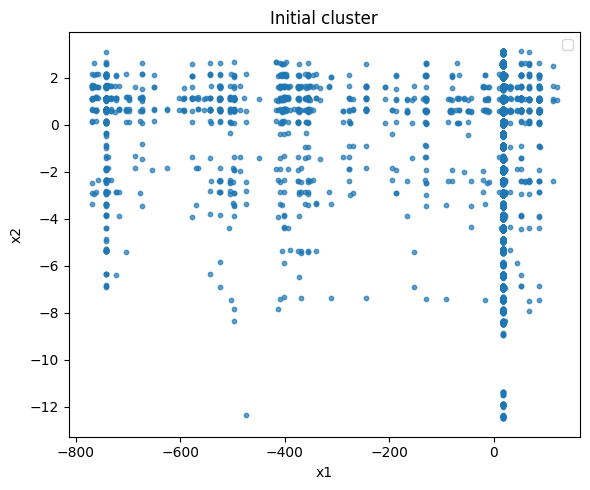

In [60]:
# Lets plot a visualization of the points to give a general idea

# Reduce to two dimensions
X_pca_2d = PCA(n_components=2).fit_transform(X_scaled)
plot_scatter(X_pca_2d, None, 'Initial cluster')

Given that:

1.   **DBSCAN** (density-based, auto-detects noise, no need for k)
2.   **BIRCH** (hierarchical + incremental, scalable)
3.   **CURE** (hierarchical with multiple representatives per cluster)
4.   **KMeans** (centroid-based, fast, assumes spherical clusters)

The initial analysis shows that the cluster is not spherical and not well-separated (possible by the reduction), it Continuous and ,manifold-like with a possibly hierarchical or density-based structure inside


Let's start with Birch

In [62]:
def describe_subclusters(model):
    scs = model.subcluster_centers_
    n_subclusters = scs.shape[0]
    print(f'Number of leaf subclusters: {n_subclusters}')
    if hasattr(model, 'labels_'):
        print(f'Final clusters (unique labels): {np.unique(model.labels_)}')

In [ ]:
from sklearn.metrics import silhouette_score

scores = {}
best_labels = None
for k in range(2, 10):
    # Fit BIRCH with a reasonable threshold
    birch = Birch(threshold=0.5, branching_factor=50, n_clusters=k)
    birch.fit(X_scaled)
    labels = birch.labels_
    scores[k] = silhouette_score(X_scaled, labels)

    if (best_labels.any()) or (scores[k-1] < scores[k]):
      best_labels = labels

    print('Silhouette score:', round(scores[k], 3))
    describe_subclusters(birch)

scores

In [64]:
from sklearn.cluster import Birch

# Given 4 has the highest score we are sticking with 4
num_clus = 4
birch = Birch(threshold=0.5, branching_factor=50, n_clusters=num_clus)
birch.fit(X_scaled)
labels = birch.labels_

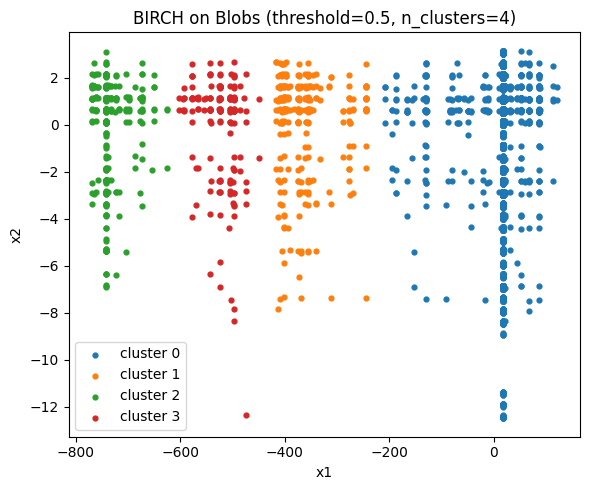

In [65]:
plot_scatter(X_pca_2d, labels, 'BIRCH on Blobs (threshold=0.5, n_clusters=4)')

In [ ]:
scores = {}
best_labels = None
best_model = None
best_thr = None
for thr in [0.2, 0.4, 0.6, 0.8]:
    model = Birch(threshold=thr, branching_factor=50, n_clusters=num_clus)
    model.fit(X_scaled)
    labels = birch.labels_
    scores[k] = silhouette_score(X_scaled, labels)

    if (best_labels.any()) or (scores[k-1] < scores[k]):
      best_labels = labels
      best_model = model
      best_thr = thr

title = f'threshold={best_thr} | #subclusters={model.subcluster_centers_.shape[0]}'
plot_scatter(X_pca_2d, labels, title)

In [87]:
df_clus['cluster_labels'] = labels

In [89]:
df_clus["cluster_labels"].unique()

array([0, 2, 3, 1])

In [90]:
df_clus[df_clus['cluster_labels'] == 0].describe()

,age,sex,date_of_first_symptoms,admission_date,fever_temperature,oxygen_saturation,history_of_fever,cough,sore_throat,runny_nose,...,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks,pcr_result,nationality_numeric,cluster_labels
count,25397.000000,25397.000000,25397.000000,25397.000000,25397.000000,25397.000000,25397.000000,25397.000000,25397.000000,25397.000000,...,25397.000000,25397.000000,25397.000000,25397.000000,25397.000000,25397.000000,25397.000000,25397.000000,25397.000000,25397.0
mean,43.103674,0.418238,738071.543332,738071.543332,37.344395,93.832764,0.510060,0.296019,0.314762,0.151396,...,0.001772,0.001811,0.001614,0.001536,0.001417,0.091586,0.001102,0.858290,791.674135,0.0
std,18.199798,0.493279,103.467896,103.467896,0.766768,4.573024,0.499909,0.456509,0.464430,0.358441,...,0.042057,0.042521,0.040147,0.039158,0.037624,0.288446,0.033186,0.348759,11.749135,0.0
min,-1.000000,0.000000,737850.000000,737850.000000,34.800000,69.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,566.000000,0.0
25%,29.000000,0.000000,737997.000000,737997.000000,36.700000,94.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,792.000000,0.0
50%,40.000000,0.000000,738081.000000,738081.000000,37.200000,95.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,792.000000,0.0
75%,56.000000,1.000000,738164.000000,738164.000000,38.000000,96.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,792.000000,0.0
max,100.000000,1.000000,738228.000000,738228.000000,40.100000,100.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,894.000000,0.0


In [94]:
df_clus[df_clus['cluster_labels'] == 1].describe()

,age,sex,date_of_first_symptoms,admission_date,fever_temperature,oxygen_saturation,history_of_fever,cough,sore_throat,runny_nose,...,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks,pcr_result,nationality_numeric,cluster_labels
count,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,...,318.0,318.0,318.0,318.000000,318.0,318.000000,318.0,318.000000,318.000000,318.0
mean,38.056604,0.355346,738093.729560,738093.729560,37.268549,93.993631,0.242138,0.166667,0.150943,0.091195,...,0.0,0.0,0.0,0.003145,0.0,0.040881,0.0,0.418239,408.893082,1.0
std,13.620936,0.479372,96.525584,96.525584,0.765813,4.283375,0.429053,0.373265,0.358558,0.288340,...,0.0,0.0,0.0,0.056077,0.0,0.198325,0.0,0.494047,48.892477,0.0
min,4.000000,0.000000,737862.000000,737862.000000,36.100000,78.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,356.000000,1.0
25%,28.000000,0.000000,738022.500000,738022.500000,36.600000,94.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,372.000000,1.0
50%,36.000000,0.000000,738116.000000,738116.000000,37.100000,95.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,398.000000,1.0
75%,45.750000,1.000000,738173.000000,738173.000000,37.875000,97.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.000000,417.000000,1.0
max,78.000000,1.000000,738225.000000,738225.000000,39.300000,99.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0,1.000000,528.000000,1.0


In [1]:
df_clus[df_clus['cluster_labels'] == 2].describe()

NameError: name 'df_clus' is not defined

In [92]:
df_clus[df_clus['cluster_labels'] == 3].describe()

,age,sex,date_of_first_symptoms,admission_date,fever_temperature,oxygen_saturation,history_of_fever,cough,sore_throat,runny_nose,...,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks,pcr_result,nationality_numeric,cluster_labels
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,...,185.0,185.0,185.0,185.0,185.0,185.000000,185.000000,185.000000,185.000000,185.0
mean,39.297297,0.443243,738079.362162,738079.362162,37.297979,93.616988,0.194595,0.145946,0.151351,0.102703,...,0.0,0.0,0.0,0.0,0.0,0.054054,0.005405,0.416216,249.902703,3.0
std,13.840836,0.498116,97.994974,97.994974,0.767114,4.600086,0.396963,0.354010,0.359364,0.304394,...,0.0,0.0,0.0,0.0,0.0,0.226738,0.073521,0.494268,32.045844,0.0
min,8.000000,0.000000,737852.000000,737852.000000,36.300000,69.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,170.000000,3.0
25%,28.000000,0.000000,737997.000000,737997.000000,36.700000,91.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,231.000000,3.0
50%,40.000000,0.000000,738088.000000,738088.000000,37.000000,95.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,250.000000,3.0
75%,48.000000,1.000000,738169.000000,738169.000000,37.900000,96.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,276.000000,3.0
max,77.000000,1.000000,738226.000000,738226.000000,39.400000,99.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,324.000000,3.0
